In [ ]:
from pathlib import Path

import numba as nb
import numpy as np
import scipy.stats as stats

from natsort import natsorted

import matplotlib.pyplot as plt


#plt.style.use("mike")
#import warnings
#warnings.simplefilter("ignore")
#warnings.filterwarnings('ignore')


import astropy.units as u

import cmasher as cmr

green = "#33FF86"
purple = "#CE33FF"

%matplotlib widget
from cosmogrb.universe.survey import Survey

import os, sys
parent_dir = os.path.abspath('..')
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

from zusammen.stan_models.stan_model import get_model
from zusammen import AnalysisBuilder, DataSet
from zusammen.spectral_plot import display_posterior_model_counts

from threeML import update_logging_level

import arviz as av


update_logging_level("FATAL")


from astromodels import Band_Calderone, PointSource, Model


from threeML import JointLikelihood, DataList, display_spectrum_model_counts

from astromodels import Cutoff_powerlaw

import popsynth as ps

Import the survey and process the GRBs

In [ ]:
survey = Survey.from_file('data/survey.h5')
ab = AnalysisBuilder(survey, use_bb=True)

In [ ]:
ab.write_yaml("test_proc.yml")

In [ ]:
ds = DataSet.from_yaml("test_proc.yml")

In [ ]:
ds.to_hdf5_file("sgrb.h5")

In [ ]:
ds.to_hdf5_file("sgrb.h5", sig_threshold=40)

In [ ]:
ds = DataSet.from_hdf5_file('sgrb.h5')

In [ ]:
ds.to_stan_dict()

In [ ]:
%matplotlib widget
i,j = 0,0
plt.plot(ds.to_stan_dict()["response"][i,j].T @ ds.to_stan_dict()['observed_counts'][i,j])

Make Stan model

In [ ]:
m = get_model("cpl_simple_chunked_gc")

In [ ]:
m.clean_model()

In [ ]:
m.build_model(opt_exp=True)

In [ ]:
data = ds.to_stan_dict()

n_threads = 2
n_chains = 2

fit = m.model.sample(
    data=data,
    parallel_chains=n_chains,
    chains=n_chains,
    inits= {
        'alpha': -1 * np.ones(data['N_intervals']),
        'log_ec': 2 * np.ones(data['N_intervals']),

        #'log_energy_flux': -7 * np.ones(data['N_intervals']),
        #'log_energy_flux_mu_raw': 0.00001,

        'gamma_sig_meta': 1,
        'log_Nrest_sig_meta': 1,
        'gamma_mu_meta': 1,
        'log_Nrest_mu_meta': 52,
        'gamma': np.ones(data['N_grbs']),
        'log_Nrest': 52 * np.ones(data['N_grbs'])
    },
    threads_per_chain=n_threads,
    seed=1234,
    iter_warmup=1000,
    iter_sampling=500,
    max_treedepth=12,
    adapt_delta=0.9,
    show_progress=True,
    #show_console=True
)

In [ ]:
fit

In [ ]:
fit.diagnose()

Import Stan results into arviz

In [ ]:
res = av.from_cmdstanpy(fit)

In [ ]:
res.to_netcdf("inference_data/testing_unconstrained_gc_2.nc")

In [ ]:
res = av.from_netcdf("inference_data/testing_gc_hierarchical_3_grbs.nc")

In [ ]:
res.sample_stats

array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'log_ec'}>,
        <AxesSubplot:title={'center':'log_ec'}>],
       [<AxesSubplot:title={'center':'log_Nrest'}>,
        <AxesSubplot:title={'center':'log_Nrest'}>],
       [<AxesSubplot:title={'center':'gamma'}>,
        <AxesSubplot:title={'center':'gamma'}>],
       [<AxesSubplot:title={'center':'gamma_mu_meta'}>,
        <AxesSubplot:title={'center':'gamma_mu_meta'}>],
       [<AxesSubplot:title={'center':'log_Nrest_mu_meta'}>,
        <AxesSubplot:title={'center':'log_Nrest_mu_meta'}>],
       [<AxesSubplot:title={'center':'gamma_sig_meta'}>,
        <AxesSubplot:title={'center':'gamma_sig_meta'}>],
       [<AxesSubplot:title={'center':'log_Nrest_sig_meta'}>,
        <AxesSubplot:title={'center':'log_Nrest_sig_meta'}>],
       [<AxesSubplot:title={'center':'ec'}>,
        <AxesSubplot:title={'center':'ec'}>],
       [<AxesSubplot:title={'center':'l

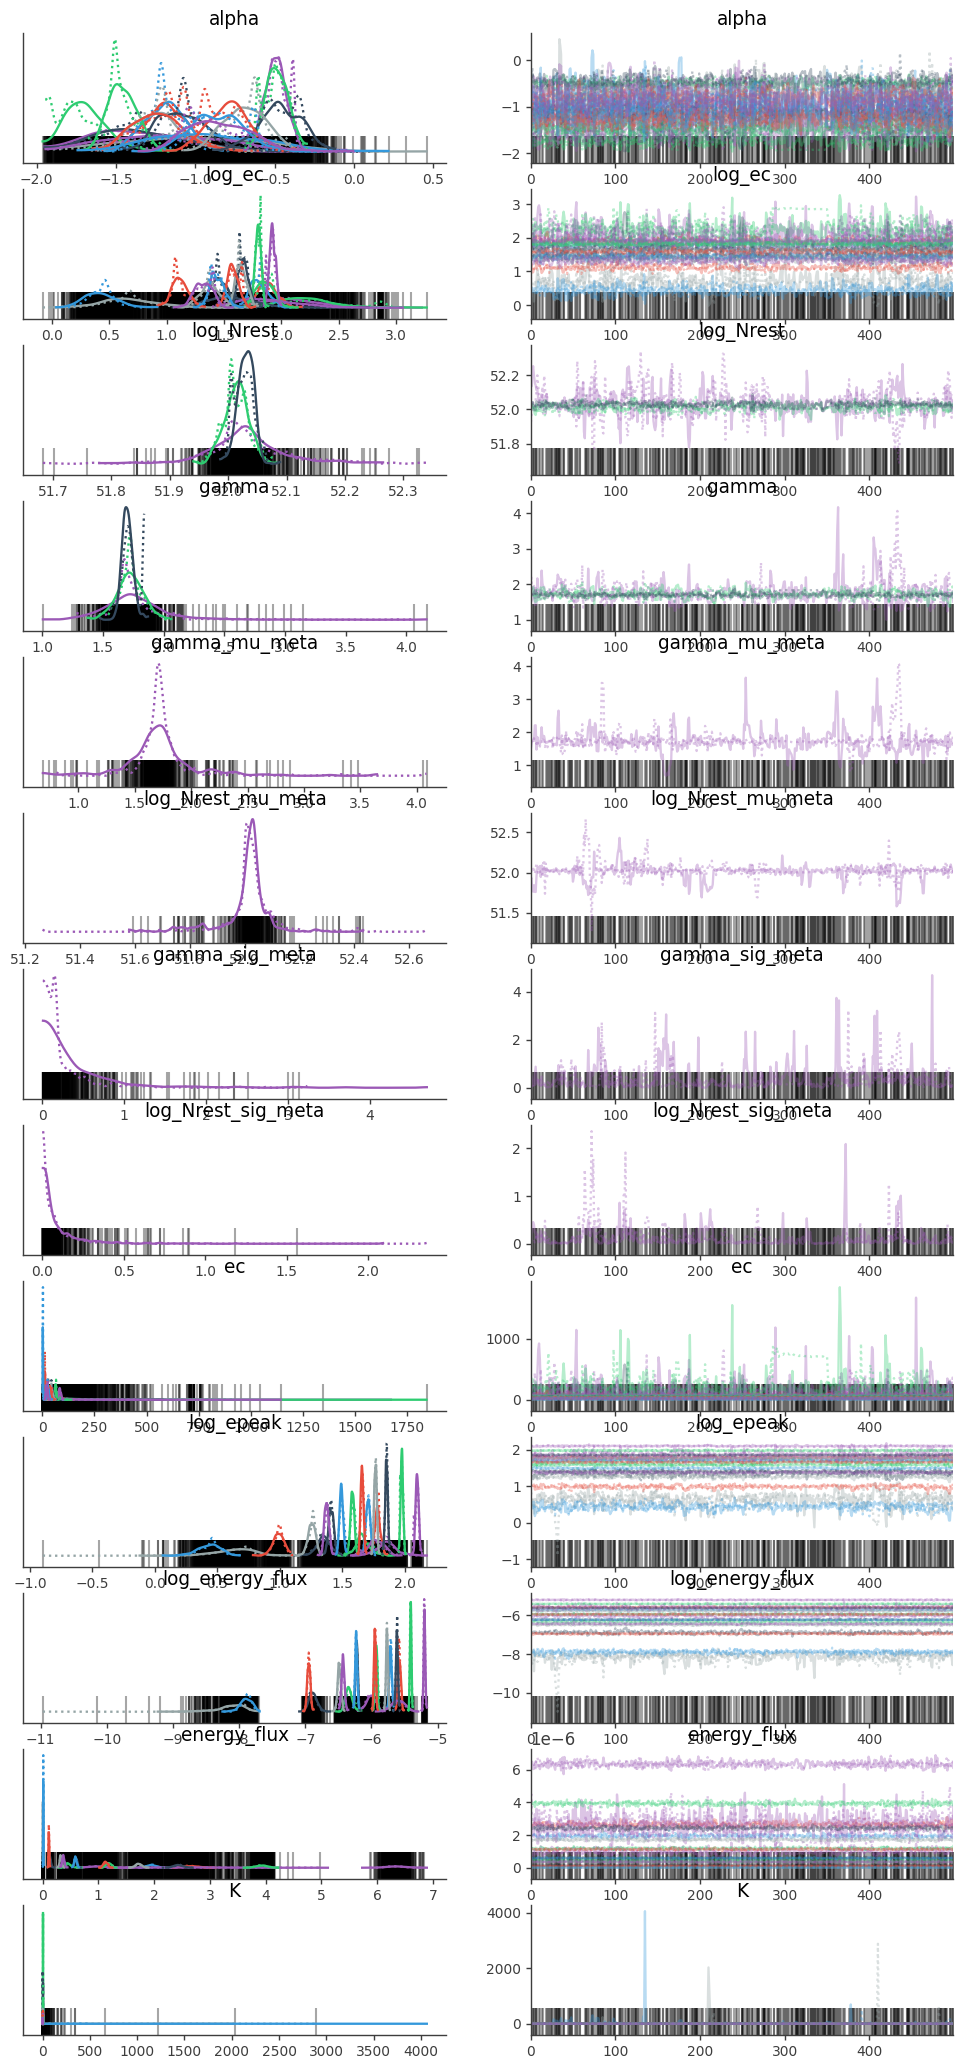

In [37]:
%matplotlib widget
av.plot_trace(res)

In [ ]:
%matplotlib widget
av.plot_pair(res, divergences=True)

In [ ]:
div = res.sample_stats.diverging.stack(sample=("chain", "draw")).values
div.sum()

Load parameters  

In [45]:
id = 0


alpha = res.posterior.alpha.stack(sample=("chain", "draw")).values[id]

log_ec = res.posterior.log_ec.stack(sample=("chain", "draw")).values[id]

K  = res.posterior.K.stack(sample=("chain", "draw")).values[id]

log_epeak = res.posterior.log_epeak.stack(sample=("chain", "draw")).values[id]

energy_flux = res.posterior.energy_flux.stack(sample=("chain", "draw")).values[id]

gamma = res.posterior.gamma.stack(sample=("chain", "draw")).values[id]

log_Nrest = res.posterior.log_Nrest.stack(sample=("chain", "draw")).values[id]


div = res.sample_stats.diverging.stack(sample=("chain", "draw")).values

samples = np.vstack((K, alpha, 10.**log_ec))


dl = ds.get_data_list_of_interval(id)

In [46]:
gamma.std()

0.2853756003284766

In [ ]:
div.sum()

In [ ]:
bc = Cutoff_powerlaw(piv=100)

bc.index.bounds = (None, None)
bc.K.bounds = (None, None)
bc.xc.bounds = (None, None)

model = Model(PointSource("ps",0,0, spectral_shape=bc))

In [ ]:
%matplotlib widget
#fig, ax = plt.subplots()

plt.scatter(log_ec, alpha, alpha=0.1)

In [ ]:
fig, ax = plt.subplots()

ax.scatter(K, alpha, alpha=0.1)

In [ ]:
display_posterior_model_counts(
    dl[1], model, samples.T[::20], min_rate=1e-99, shade=False
)

In [ ]:
cpl = Cutoff_powerlaw(piv=100,K=1e-1,xc=200)


dl = ds.get_data_list_of_interval(2)

model = Model(PointSource("ps",0,0, spectral_shape=cpl))

ba = JointLikelihood(model,DataList(*dl))

In [ ]:
ba.fit()

In [ ]:
display_spectrum_model_counts(ba)

In [ ]:
dl[0].view_count_spectrum()

In [ ]:
cpl